In [63]:
# imports

import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('./revised_with_selftext.csv', index_col = 0)
df.head()

,subreddit,selftext,title,tokenized,title_selftext,title_selftext_word_count,title_selftext_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"['percentage', 'of', 'paycheck', 'into', 'defe...",percentage of paycheck into deferred comp plan...,121,682
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"['old', 'first', 'car', 'you', 'know', 'the', ...",19yrs old first car (you know the drill)So I’m...,94,444
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","['other', 'driver', 'ran', 'into', 'me', 'but'...","other driver ran into me, but i don't have ins...",157,801
3,1,,need help with a parent who’s reluctant to beg...,"['need', 'help', 'with', 'a', 'parent', 'who',...",need help with a parent who’s reluctant to beg...,14,77
4,1,,how do i buy a house? how do i qualify? what’s...,"['how', 'do', 'i', 'buy', 'a', 'house', 'how',...",how do i buy a house? how do i qualify? what’s...,13,60


In [5]:
df.isnull().sum()

subreddit                    0
selftext                     0
title                        0
tokenized                    0
title_selftext               0
title_selftext_word_count    0
title_selftext_length        0
dtype: int64

In [6]:
df.describe()

,subreddit,title_selftext_word_count,title_selftext_length
count,4418.000000,4418.000000,4418.000000
mean,0.674061,115.158669,630.043006
std,0.468778,141.852067,786.951645
min,0.000000,1.000000,4.000000
25%,0.000000,16.000000,88.000000
50%,1.000000,82.000000,450.000000
75%,1.000000,153.000000,835.000000
max,1.000000,2110.000000,12446.000000


## Lets see if combining self text with title makes any difference in performance!

In [7]:
df['subreddit'].value_counts(normalize = True)

1    0.674061
0    0.325939
Name: subreddit, dtype: float64

In [8]:
X = df['title_selftext']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)


In [10]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

1    0.674011
0    0.325989
Name: subreddit, dtype: float64
1    0.674208
0    0.325792
Name: subreddit, dtype: float64


## Logistic Regression

In [11]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 100_000))
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__stop_words': [None, 'english'],
    'tfid__ngram_range': [(1, 1), (2,2)],
    'tfid__norm': ['l1', 'l2']
    
    
    
}

gs_lr_tf = GridSearchCV(pipe,
                 param_grid=pipe_params,
                 n_jobs = -1)

gs_lr_tf.fit(X_train, y_train)
print(gs_lr_tf.best_score_) # from cross_val
gs_lr_tf.best_params_

0.7841856798494439


{'tfid__max_features': 3000,
 'tfid__ngram_range': (1, 1),
 'tfid__norm': 'l2',
 'tfid__stop_words': None}

* Accuracy

In [12]:
print(f' Training Accuracy Score: {gs_lr_tf.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_lr_tf.score(X_test, y_test)}')

 Training Accuracy Score: 0.8511922728644733
 Test Accuracy Score: 0.7900452488687782


* Misclassification

In [13]:
print(f' Training Misclassification Rate: {1 - gs_lr_tf.score(X_train, y_train)}')
print(f' Test Misclassification Rate: {1 - gs_lr_tf.score(X_test, y_test)}')

 Training Misclassification Rate: 0.1488077271355267
 Test Misclassification Rate: 0.20995475113122175


* Preds / F1

In [14]:
predslrtf = gs_lr_tf.best_estimator_.predict(X_test)


In [15]:
f1_score(y_test, predslrtf)

0.8562577447335812

### Decision Tree

In [16]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__stop_words': [None, 'english'],
    'tfid__ngram_range': [(1, 1), (2,2)],
    'tfid__norm': ['l1', 'l2']
    
}

gs_dt = GridSearchCV(pipe,
                    param_grid = pipe_params, cv=3,
                    n_jobs = -1)

gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)

{'tfid__max_features': 2000, 'tfid__ngram_range': (1, 1), 'tfid__norm': 'l2', 'tfid__stop_words': None}


* Accuracy

In [17]:
print(f' Training Accuracy Score: {gs_dt.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_dt.score(X_test, y_test)}')

 Training Accuracy Score: 0.9975852701479022
 Test Accuracy Score: 0.7357466063348417


* Misclassification

In [18]:
print(f' Training Misclassification Rate: {1 - gs_dt.score(X_train, y_train)}')
print(f' Test Misclassification Rate: {1 - gs_dt.score(X_test, y_test)}')

 Training Misclassification Rate: 0.0024147298520977856
 Test Misclassification Rate: 0.2642533936651583


* Preds / F1

In [19]:
predsdt = gs_dt.predict(X_test)

In [20]:
f1_score(y_test, predsdt)

0.8029689608636977

### Multinomial Naive Bayes


In [21]:
nb_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

nb_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2)],
    'tfid__norm': ['l1', 'l2']
}

gs_nb = GridSearchCV(nb_pipe,
                    param_grid = nb_pipe_params, cv = 5,
                    n_jobs = -1)

gs_nb.fit(X_train, y_train)
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.7485693975475387
{'tfid__max_features': 2000, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 1), 'tfid__norm': 'l2', 'tfid__stop_words': None}


* Accuracy

In [22]:
print(f' Training Accuracy Score: {gs_nb.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_nb.score(X_test, y_test)}')

 Training Accuracy Score: 0.7829761545427105
 Test Accuracy Score: 0.7574660633484163


* Misclassification

In [23]:
print(f' Training Misclassification Score: {1 - gs_nb.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_nb.score(X_test, y_test)}')

 Training Misclassification Score: 0.21702384545728948
 Testtest Misclassification Score: 0.24253393665158374


* Preds / F1

In [24]:
preds_nb = gs_nb.predict(X_test)

In [25]:
f1_score(y_test, preds_nb)

0.8438228438228438

### KNeighbors

In [26]:

knn_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

knn_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_knn = GridSearchCV(knn_pipe,
                    param_grid = knn_pipe_params, cv = 5,
                    n_jobs = -1)

gs_knn.fit(X_train, y_train)
print(gs_knn.best_score_)
print(gs_knn.best_params_)

/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

0.5469216643199226
{'tfid__max_features': 1000, 'tfid__min_df': 4, 'tfid__ngram_range': (1, 3), 'tfid__norm': 'l1', 'tfid__stop_words': None}


* Accuracy

In [27]:
print(f' Training Accuracy Score: {gs_knn.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_knn.score(X_test, y_test)}')

 Training Accuracy Score: 0.6483549652882584
 Test Accuracy Score: 0.5212669683257919


* Misclassification

In [28]:
print(f' Training Misclassification Score: {1 - gs_knn.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_knn.score(X_test, y_test)}')

 Training Misclassification Score: 0.3516450347117416
 Testtest Misclassification Score: 0.4787330316742081


* Preds / F1

In [29]:
preds_knn = gs_knn.predict(X_test)

In [30]:
f1_score(y_test, preds_knn)

0.5681632653061225

### Bagging  

In [31]:
bagg_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bagg', KNeighborsClassifier())
])

bagg_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_bagg = GridSearchCV(bagg_pipe,
                    param_grid = bagg_pipe_params, cv = 5,
                    n_jobs = -1)

gs_bagg.fit(X_train, y_train)
print(gs_bagg.best_score_)
print(gs_bagg.best_params_)

# with warnings.catch_warnings():
#  warnings.filterwarnings("ignore")

/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/oseianom/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

0.5469216643199226
{'tfid__max_features': 1000, 'tfid__min_df': 4, 'tfid__ngram_range': (1, 3), 'tfid__norm': 'l1', 'tfid__stop_words': None}


* Accuracy

In [32]:
print(f' Training Accuracy Score: {gs_bagg.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_bagg.score(X_test, y_test)}')

 Training Accuracy Score: 0.6483549652882584
 Test Accuracy Score: 0.5212669683257919


* Misclassification

In [33]:
print(f' Training Misclassification Score: {1 - gs_bagg.score(X_train, y_train)}')
print(f' Test Misclassification Score: {1 - gs_bagg.score(X_test, y_test)}')

 Training Misclassification Score: 0.3516450347117416
 Test Misclassification Score: 0.4787330316742081


* Preds / F1

In [34]:
preds_bagg = gs_bagg.predict(X_test)

In [35]:
f1_score(y_test, preds_bagg)

0.5681632653061225

 - decreased accuracy, increased misclassification, lowered F1 score

### Random Forest

In [36]:
rf_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_rf = GridSearchCV(rf_pipe,
                    param_grid = rf_pipe_params, cv = 5,
                    n_jobs = -1)

gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.7832825251876256
{'tfid__max_features': 3000, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 2), 'tfid__norm': 'l2', 'tfid__stop_words': None}


* Accuracy

In [37]:
print(f' Training Accuracy Score: {gs_rf.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_rf.score(X_test, y_test)}')

 Training Accuracy Score: 0.9966797464533655
 Test Accuracy Score: 0.7819004524886878


* super overfit!

* Misclassification

In [38]:
print(f' Training Misclassification Score: {1 - gs_rf.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_rf.score(X_test, y_test)}')

 Training Misclassification Score: 0.003320253546634455
 Testtest Misclassification Score: 0.21809954751131222


* Preds / F1

In [39]:
preds_rf = gs_rf.predict(X_test)

In [40]:
f1_score(y_test, preds_rf)

0.8505889646621202

 - increased F1, decreased misclassification, but lowered accuracy

### AdaBoost

In [41]:
ada_pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

ada_pipe_params = {
    'tfid__stop_words':[None, 'english'],
    'tfid__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfid__min_df': [2, 3, 4],
    'tfid__ngram_range':[(1,1), (1,2),(1,3)],
    'tfid__norm': ['l1', 'l2']
}

gs_ada = GridSearchCV(ada_pipe,
                    param_grid = ada_pipe_params, cv = 5,
                    n_jobs = -1)

gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

0.769099989519396
{'tfid__max_features': 1000, 'tfid__min_df': 3, 'tfid__ngram_range': (1, 1), 'tfid__norm': 'l2', 'tfid__stop_words': None}


* Accuracy

In [42]:
print(f' Training Accuracy Score: {gs_ada.score(X_train, y_train)}')
print(f' Test Accuracy Score: {gs_ada.score(X_test, y_test)}')

 Training Accuracy Score: 0.801086628433444
 Test Accuracy Score: 0.783710407239819


* Misclassification

In [43]:
print(f' Training Misclassification Score: {1 - gs_ada.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - gs_ada.score(X_test, y_test)}')

 Training Misclassification Score: 0.19891337156655597
 Testtest Misclassification Score: 0.216289592760181


* Preds / F1

In [44]:
preds_ada = gs_ada.predict(X_test)

In [45]:
f1_score(y_test, preds_ada)

0.8403473613894457

### Stacking

In [46]:
level1_estimators = [
    ('nb', gs_nb.best_estimator_),
    ('ada', gs_ada.best_estimator_),
    ('rf', gs_rf.best_estimator_)
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

In [47]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('nb',
                                Pipeline(steps=[('tfid',
                                                 TfidfVectorizer(max_features=2000,
                                                                 min_df=2)),
                                                ('mnb', MultinomialNB())])),
                               ('ada',
                                Pipeline(steps=[('tfid',
                                                 TfidfVectorizer(max_features=1000,
                                                                 min_df=3)),
                                                ('ada',
                                                 AdaBoostClassifier())])),
                               ('rf',
                                Pipeline(steps=[('tfid',
                                                 TfidfVectorizer(max_features=3000,
                                                                 min_df=2,
                         

* Accuracy

In [48]:
print(f' Training Accuracy Score: {stacked_model.score(X_train, y_train)}')
print(f' Test Accuracy Score: {stacked_model.score(X_test, y_test)}')

 Training Accuracy Score: 0.9577422275882885
 Test Accuracy Score: 0.8090497737556561


* Misclassification

In [49]:
print(f' Training Misclassification Score: {1 - stacked_model.score(X_train, y_train)}')
print(f' Testtest Misclassification Score: {1 - stacked_model.score(X_test, y_test)}')

 Training Misclassification Score: 0.04225777241171147
 Testtest Misclassification Score: 0.19095022624434388


* Preds / F1

In [50]:
preds_stacked_model = stacked_model.predict(X_test)

In [51]:
f1_score(y_test, preds_stacked_model)

0.8646568313021167

still the best performer - increased accuracy, decreased misclassification, and increased F1 scores

### Visualization of Eval

In [57]:
# resids = y_test - preds_stacked_model

In [58]:
# resids = y_test - preds_stacked_model


In [59]:

# plt.hist(resids);
# plt.title('Residuals of Predictions of Stacked Model (Test Data)');
# plt.xlabel('Actual Rating Classfication versus Predicted Classficiation');
# plt.ylabel('Count');

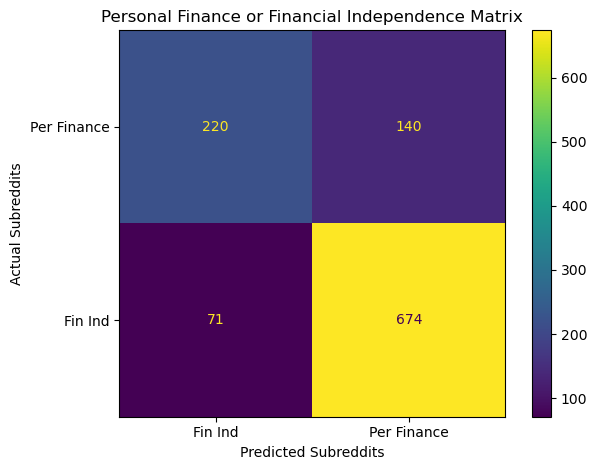

In [92]:
plot_confusion_matrix(stacked_model, X_test, y_test);

# ax.set_title('Personal Finance or Financial Independence Matrix');
# ax.set_xlabel('Predicted Subreddits')
# ax.set_ylabel('Actual Subreddits');

plt.xlabel('Predicted Subreddits')
plt.ylabel('Actual Subreddits')
plt.title('Personal Finance or Financial Independence Matrix');

# plt.xticks(np.arange(0, 1)

plt.xticks([0, 1], ['Fin Ind', 'Per Finance'])
plt.yticks([1, 0], ['Fin Ind', 'Per Finance'])

plt.tight_layout()
plt.savefig('../images/confusion matrix.jpg')

* results: the model is over predicting 1's(personal finance subreddit - false positives), partially due to the imbalance of classes, note there are two times as many false positives as false negatives